In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

# local imports
%load_ext autoreload
%autoreload 2
from models import VariationalAutoencoder, ImportanceWeightedAutoencoder

Create datasets using torchvision

<IPython.core.display.Javascript object>


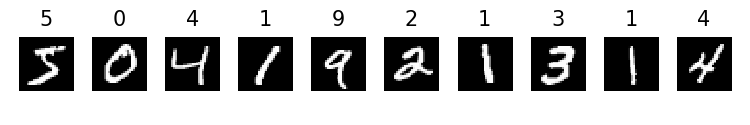

In [2]:
import torchvision
path_to_datasets = '~/datasets'
mnist_train_data = torchvision.datasets.MNIST(path_to_datasets, train=True, download=True,
                                              transform=torchvision.transforms.ToTensor())
mnist_test_data = torchvision.datasets.MNIST(path_to_datasets, train=False, download=True,
                                             transform=torchvision.transforms.ToTensor())

fig, ax = plt.subplots(1, 10, figsize=(6, 1), tight_layout=True)
for i in range(10):
    image, label = mnist_train_data[i]
    ax[i].imshow(image.numpy()[0, :, :], cmap=plt.cm.Greys_r)
    ax[i].axis('off')
    ax[i].set_title(label)

Prepare dataloaders

In [4]:
from torch.utils.data import DataLoader, SubsetRandomSampler

np.random.seed(0)
idx = list(range(len(mnist_train_data)))
#idx = list(range(10000))
np.random.shuffle(idx)
split = int(0.7*len(idx))

train_loader = DataLoader(mnist_train_data, batch_size=32, drop_last=True,
                          sampler=SubsetRandomSampler(idx[:split]))

valid_loader = DataLoader(mnist_train_data, batch_size=128, drop_last=True,
                          sampler=SubsetRandomSampler(idx[split:]))

test_loader = DataLoader(mnist_test_data, batch_size=1024, drop_last=False, shuffle=False)

Train the model (or skip this and load last model)

In [5]:
torch.manual_seed(1234)

#model = VariationalAutoencoder(latent_dim=2, data_dim=28*28)
model = ImportanceWeightedAutoencoder(latent_dim=2, data_dim=28*28)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def normalize_data(x):
    x = x.reshape(-1, 28*28)
    x = (x - torch.mean(x, dim=1, keepdim=True))/torch.std(x, dim=1, keepdim=True)
    return x

for epoch in range(50):
    epoch_loss = 0.0
    for x, label in train_loader:        
        x = normalize_data(x)
        optimizer.zero_grad()
        loss = model.negELBO(x, mc_samples=10)[0]
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    # Log and checkpoint
    if np.mod(epoch, 10) == 0:
        print(f"{epoch} {epoch_loss}")
        torch.save({'current_epoch': epoch, 
                    'model_state_dict': model.state_dict()}, 
                   'mnist_vae_last.pt')

0 12552002.119140625
10 6882417.197509766
20 6155748.551879883


KeyboardInterrupt: 

Load final model

In [ ]:
model = ImportanceWeightedAutoencoder(latent_dim=2, data_dim=28*28)
model.load_state_dict(torch.load('mnist_vae_last.pt')['model_state_dict'])

Latent space

<IPython.core.display.Javascript object>


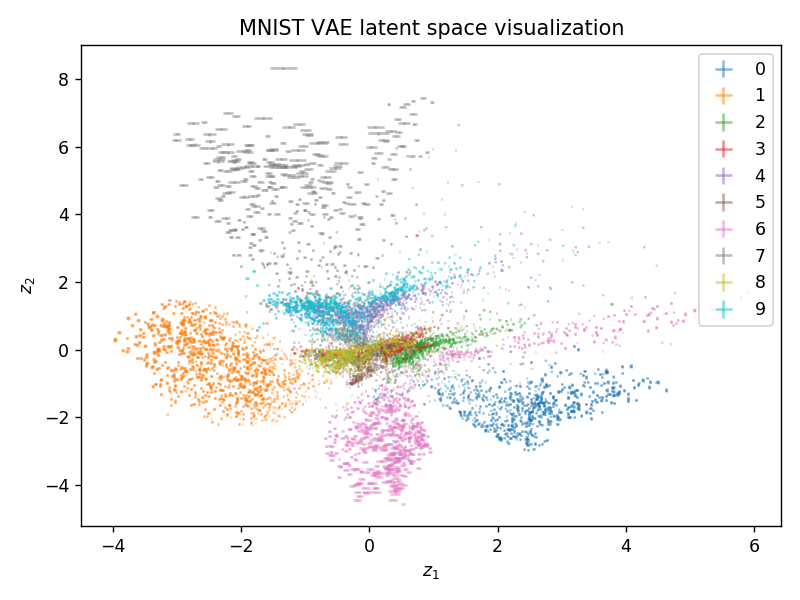

In [6]:
fig, ax = plt.subplots(tight_layout=True)
Z_mu, Z_std = torch.tensor([]), torch.tensor([])
for x, label in test_loader:
    x = normalize_data(x)
    z_mu, z_logvar = model.encoder(x)
    Z_mu = torch.cat((Z_mu, z_mu))
    Z_std = torch.cat((Z_std, (0.5*z_logvar).exp()))
Z_mu = Z_mu.detach().cpu().numpy()
Z_std = Z_std.detach().cpu().numpy()

for digit in range(10):
    mask = mnist_test_data.targets == digit
    ax.errorbar(Z_mu[mask, 0], Z_mu[mask, 1],
                Z_std[mask, 0], Z_std[mask, 1], fmt='none',
                alpha=0.5, cmap=plt.cm.tab10, label=str(digit))
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_title('MNIST VAE latent space visualization')
plt.legend()

Reconstructions

<IPython.core.display.Javascript object>


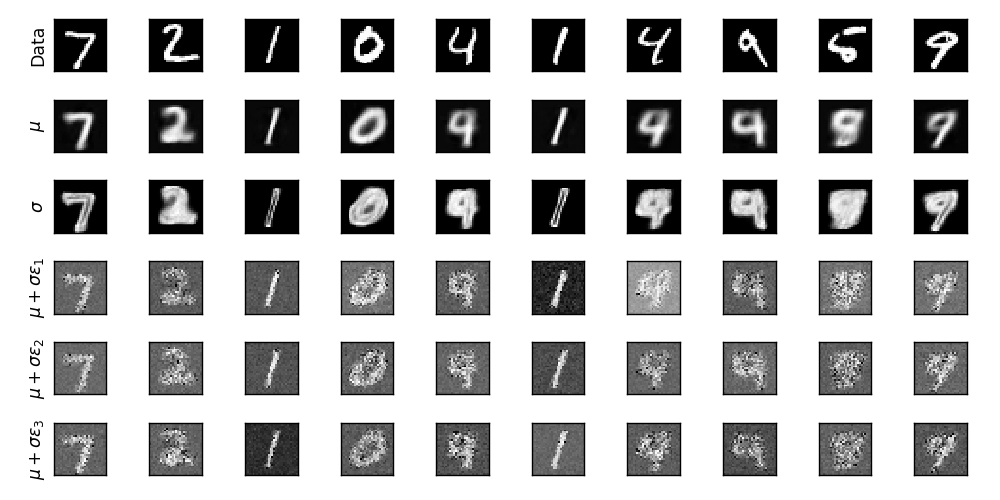

In [7]:
x, label = next(iter(test_loader))
x = normalize_data(x)
dec_output, enc_output, z = model.forward(x)
dec_mu, dec_logvar = dec_output
dec_mu = dec_mu.reshape(-1, 28, 28)
dec_std = (0.5*dec_logvar).exp().reshape(-1, 28, 28) #diagonal
#dec_std = (0.5*dec_logvar).exp().repeat(1, 28, 28) #spherical

fig, ax = plt.subplots(6, 10, figsize=(8, 4), tight_layout=True, sharey=True)
for ax_ in ax.ravel():
    ax_.get_xaxis().set_ticks([])
    ax_.get_yaxis().set_ticks([])

for i in range(10):
    ax[0, i].imshow(x.detach().cpu().numpy().reshape(-1, 28, 28)[i], cmap=plt.cm.Greys_r) # Data
    ax[0, 0].set_ylabel('Data')
    ax[1, i].imshow(dec_mu.detach().cpu().numpy()[i], cmap=plt.cm.Greys_r) # Mean
    ax[1, 0].set_ylabel(r'$\mu$')
    ax[2, i].imshow(dec_std.detach().cpu().numpy()[i], cmap=plt.cm.Greys_r) # Std
    ax[2, 0].set_ylabel(r'$\sigma$')
    for j in range(3): # 3 realizations N(Mean, Std^2)
        xhat = dec_mu + torch.randn_like(dec_std)*dec_std
        ax[3+j, i].imshow(xhat.detach().numpy()[i], cmap=plt.cm.Greys_r)
        ax[3+j, 0].set_ylabel(f'$\mu + \sigma\epsilon_{j+1}$')
    